# Specify perturbation

In [1]:
import numpy as np

Ne = 10 # number of perturbation
amean = 20.0
bmean = 5.0
a_std = 2.0
b_std = 0.5
aw = np.random.normal(amean, a_std, Ne)  # perturbation in a
bw = np.random.normal(bmean, b_std, Ne)  # perturbation in b

aw, bw

(array([21.33475586, 22.34223509, 19.30977293, 17.1096296 , 20.89934636,
        19.63353215, 16.56611449, 19.4582751 , 18.93305358, 23.15931784]),
 array([5.84997699, 5.8895987 , 4.62704057, 4.58838645, 6.03736705,
        4.63427309, 5.01686782, 4.00604146, 5.30302979, 5.48509878]))

# Stochastic OCP for initial state x0 

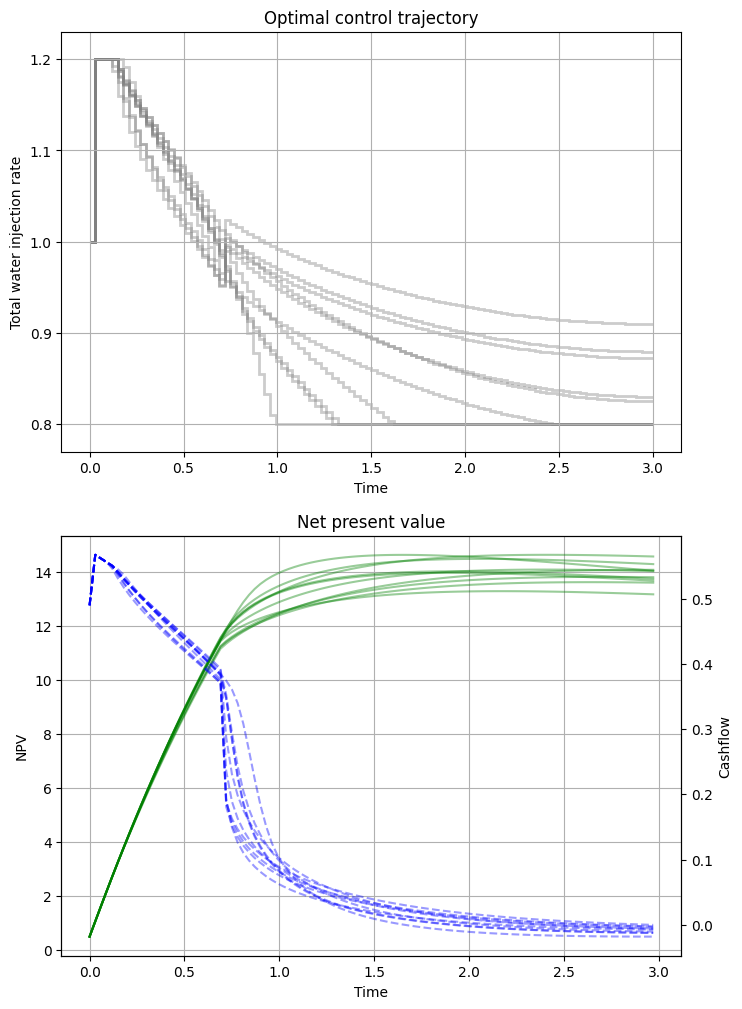

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

params_mpcs = [BLParamsMpc(a=a, b=b) for a,b in zip(aw, bw)]

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpcs[0].umin-0.03, params_mpcs[0].umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)
    
ocp_x_trajs = []
ocp_u_trajs = []
ocp_cashflows = []
for i in range(Ne):

    params_mpc = params_mpcs[i]
    ocp = setup_bl_ocp(params_mpc)
    solver = SolverOcp(ocp)


    Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
    qt = np.array([1.0]*params_mpc.N)  # initial guess for control

    solver.set_initial_guess(Sw0, qt)
    x_traj, u_traj = solver.solve(Sw0)

    T = np.array(range(params_mpc.N+1))*params_mpc.dt

    # plot control trajectory
    axs[0].stairs(u_traj[0,:], T, label='u', baseline=None, orientation='vertical', linewidth=2, color="grey", alpha=0.4, )


    # plot the cost
    cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
    ocp_cashflow = np.zeros(params_mpc.N)
    npv = []
    for k in range(params_mpc.N):
        ocp_cashflow[k] = -cost_function(u_traj[0,k], x_traj[:,k])*0.99**(k)
        npv.append(ocp_cashflow[k] if k==0 else npv[-1] + ocp_cashflow[k])
            
    axs[1].plot(T[:-1], npv, color="green", alpha=0.4, label='NPV')
    

    # plot twin axis for cashflow
    # ax1 = axs[1].gca()
    if i == 0:
        ax = axs[1].twinx()
        ax.set_ylabel("Cashflow")
    
    ax.plot(T[:-1], ocp_cashflow, '--', label='Cashflow', color="blue", alpha=0.4)
    
    # plt.show()

    ocp_x_traj = x_traj*1
    ocp_u_traj = u_traj*1

    ocp_npv = npv*1
    
    ocp_x_trajs.append(ocp_x_traj)
    ocp_u_trajs.append(ocp_u_traj)
    ocp_cashflows.append(ocp_cashflow)

np.save("./data/stochastic_ocp_cashflows.npy", ocp_cashflows)
np.save("./data/stochastic_ocp_sw_trajs.npy", ocp_x_trajs)
np.save("./data/stochastic_ocp_qts.npy", ocp_u_trajs)

In [3]:
n_mpc_steps = 100

# Stochastic Model Predictive Control with Moving Horizon 
(time window = 3 sec (N = 100, dt = 0.03))

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_bl import setup_bl_ocp, BLParamsMpc
from solver_ocp import SolverOcp

if True: # long running simulation
    params_mpcs = [BLParamsMpc(a=a, b=b) for a,b in zip(aw, bw)]
        
    cashflow_fulls = []
    Sw_traj_fulls = []
    qt_mpc_fulls = []

    for i in range(Ne):
        Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
        qt = np.array([1.0]*params_mpc.N)  # initial guess for control

        qt_sol = []
        Sw_mpc = Sw0.copy()
        qt_mpc = []
        Sw_traj = [Sw_mpc.copy()]
        cashflow = []
        npv_mpc = [0.0]
        for mpc_step in tqdm(range(n_mpc_steps)):

            # update stage constraint
            params_mpc.uinit = qt[0]

            # solve OCP
            ocp = setup_bl_ocp(params_mpc)
            cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
            f_discrete = ca.Function("f_discrete", [ocp.u, ocp.x], [ocp.dyn_expr])

            solver = SolverOcp(ocp, itk=mpc_step)
            
            solver.set_initial_guess(Sw_mpc, qt)
            x_traj, u_traj = solver.solve(Sw_mpc)
            qt_sol.append(u_traj[0,0]*1)
            
            # apply the first control move
            qt_mpc.append(u_traj[0,:])
            Sw_mpc = f_discrete(u_traj[0,0], Sw_mpc).full()[:,0]
            
            Sw_traj.append(Sw_mpc)
            cashflow.append(-(cost_function(u_traj[0,0], Sw_mpc)*0.99**(mpc_step)).full()[0,0])
            npv_mpc.append((npv_mpc[-1] + cashflow[mpc_step]))
            
            # shift the control trajectory
            qt = np.hstack((u_traj[0,1:], u_traj[0,-1]))
            
        cashflow_full = np.array(cashflow)
        Sw_traj_full = np.array(Sw_traj)
        qt_mpc_full = np.array(qt_mpc)
        
        cashflow_fulls.append(cashflow_full)
        Sw_traj_fulls.append(Sw_traj_full)
        qt_mpc_fulls.append(qt_mpc_full)

    np.save("./data/stochastic_cashflow_fulls.npy", cashflow_fulls)
    np.save("./data/stochastic_sw_traj_fulls.npy", Sw_traj_fulls)
    np.save("./data/stochastic_qt_mpc_fulls.npy", qt_mpc_fulls)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 100, 100)

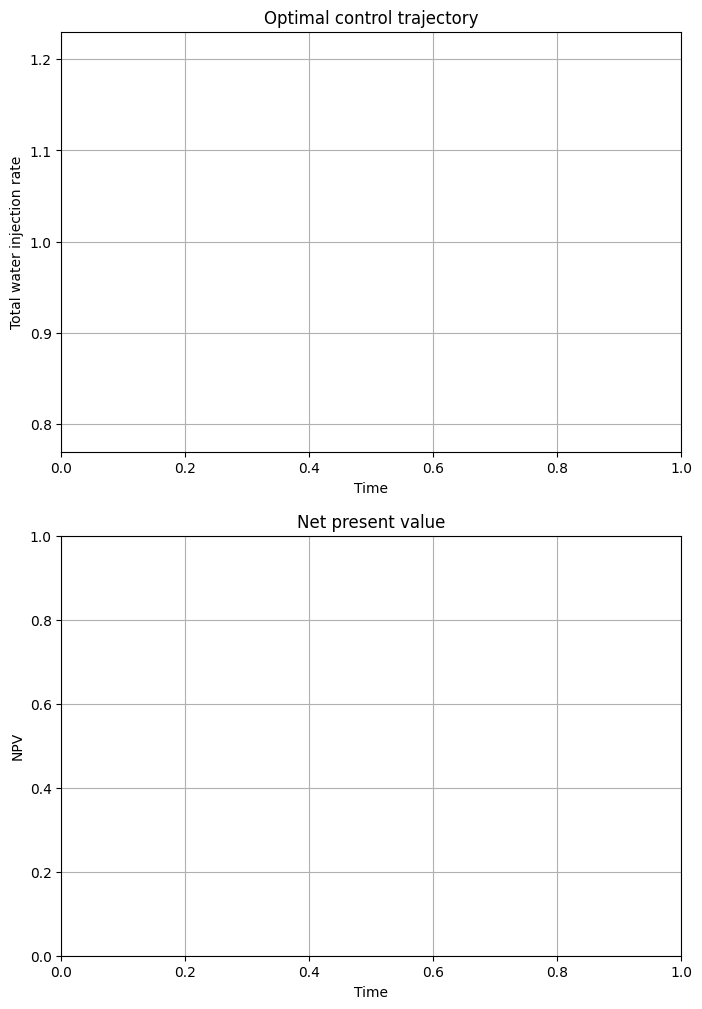

In [ ]:
cashflow_fulls = np.load("./data/stochastic_cashflow_fulls.npy")
Sw_traj_fulls = np.load("./data/stochastic_sw_traj_fulls.npy")
qt_mpc_fulls = np.load("./data/stochastic_qt_mpc_fulls.npy")

ocp_cashflows = np.load("./data/stochastic_ocp_cashflows.npy")
ocp_x_trajs = np.load("./data/stochastic_ocp_sw_trajs.npy")
ocp_u_trajs = np.load("./data/stochastic_ocp_qts.npy")

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpcs[0].umin-0.03, params_mpcs[0].umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)

axs[0].plot(qt_mpc_fulls)

# qt_mpc_fulls


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].set_ylim(params_mpcs[0].umin-0.03, params_mpcs[0].umax+0.03)
axs[0].set_title('Optimal control trajectory')
axs[0].set_ylabel('Total water injection rate')
axs[0].set_xlabel('Time')
axs[0].grid(True)

axs[1].set_xlabel('Time')
axs[1].set_ylabel('NPV')
axs[1].set_title('Net present value')
axs[1].grid(True)
    

# Model Predictive Control with Moving Horizon 
(time window = 1.5 sec (N = 100, dt = 0.03))

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

from setup_bl import setup_bl_ocp, BLParamsMpcShort
from solver_ocp import SolverOcp

# simulate MPC by applying the first control move and shifting
params_mpc = BLParamsMpcShort()
n_mpc_steps = 100

Sw0 = np.array([1.0]+[0.2]*(params_mpc.nx-1))  # initial state
qt = np.array([1.0]*params_mpc.N)  # initial guess for control

qt_sol = []
Sw_mpc = Sw0.copy()
qt_mpc = []
Sw_traj = [Sw_mpc.copy()]
cashflow = []
npv_mpc = [0.0]
for mpc_step in range(n_mpc_steps):
    print(f'MPC step {mpc_step+1}/{n_mpc_steps}')

    # update stage constraint
    params_mpc.uinit = qt[0]
    
    # solve OCP
    ocp = setup_bl_ocp(params_mpc)
    cost_function = ca.Function('cost_function', [ocp.u, ocp.x], [ocp.stage_cost_expr])
    f_discrete = ca.Function("f_discrete", [ocp.u, ocp.x], [ocp.dyn_expr])

    solver = SolverOcp(ocp, itk=mpc_step)
    
    solver.set_initial_guess(Sw_mpc, qt)
    x_traj, u_traj = solver.solve(Sw_mpc)
    qt_sol.append(u_traj[0,0]*1)
    
    # apply the first control move
    qt_mpc.append(u_traj[0,:])
    Sw_mpc = f_discrete(u_traj[0,0], Sw_mpc).full()[:,0]
    
    Sw_traj.append(Sw_mpc)
    cashflow.append(-(cost_function(u_traj[0,0], Sw_mpc)*0.99**(mpc_step)).full()[0,0])
    npv_mpc.append((npv_mpc[-1] + cashflow[mpc_step]))
    
    # shift the control trajectory
    qt = np.hstack((u_traj[0,1:], u_traj[0,-1]))
    
cashflow_half = np.array(cashflow)
Sw_traj_half = np.array(Sw_traj)
qt_mpc_half = np.array(qt_mpc)

# State and control trajectories at each time steps

In [ ]:
plt.figure()
for i in range(n_mpc_steps):
    
    if i % 1 == 0:
        if i==0:
            T = np.arange(0, n_mpc_steps*params_mpc.dt, params_mpc.dt)
            plt.plot(T, qt_mpc_full[:,i], label=f'Step {i+1}')
        else:
            T = np.arange(0, n_mpc_steps*params_mpc.dt, params_mpc.dt)[i:]
            plt.plot(T, qt_mpc_full[:-(i),i], label=f'Step {i+1}')

plt.xlabel('Time')
plt.ylabel('Total water injection rate')
plt.title('MPC solutions control trajectory')
plt.grid(True)
# plt.legend()

plt.figure()
for i in range(n_mpc_steps):
    if i % 10 == 0:
        plt.plot(range(params_mpc.nx), Sw_traj_full[i,:], label=f'Step {i+1}')
plt.xlabel('Length')
plt.ylabel('Water saturation')
plt.title('MPC State trajectory')
plt.grid(True)

# Comparing results of OCP vs MPC with long horizon (full) vs MPC with short horizon (half)

In [ ]:
# plot control trajectory
plt.figure()
T = np.arange(0, params_mpc.total_time, params_mpc.dt)[:n_mpc_steps-1]
plt.stairs(T, qt_mpc_full[:,0], orientation='horizontal', label='MPC control full', baseline=None, linewidth=2)
plt.stairs(T, qt_mpc_half[:,0], orientation='horizontal', label='MPC control half', baseline=None, linewidth=2)
plt.stairs(T, ocp_u_traj[0,:], orientation='horizontal', label='OCP control', baseline=None, linewidth=2)
plt.legend()
plt.title('Optimal control trajectory')
plt.ylabel('Total water injection rate')
plt.xlabel('Time')

# plot NPV trajectory
plt.figure()
# T = np.arange(0, params_mpc.total_time, params_mpc.dt)
T = np.arange(0, params_mpc.total_time, params_mpc.dt)[:n_mpc_steps]
npv_full = np.cumsum(cashflow_full)
npv_half = np.cumsum(cashflow_half)
plt.plot(T, npv_full, label='MPC NPV full', linewidth=2)
plt.plot(T, npv_half, label='MPC NPV half', linewidth=2)
plt.plot(T, ocp_npv, label='OCP NPV', linewidth=2)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.set_ylabel('Cashflow')
ax2.plot(T, cashflow_full, '--', label='MPC cashflow full', linewidth=2)
ax2.plot(T, cashflow_half, '--', label='MPC cashflow half', linewidth=2)
ax2.plot(T, ocp_cashflow, '--', label='OCP cashflow', linewidth=2)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.title('Optimal Net present value')
ax2.set_ylabel('Cashflow')
plt.grid(True)
plt.legend(loc="center right")
plt.show()

# Run with MPC solutions (sanity check)

In [ ]:
from buckley_leverette_ori import BuckleyLeverette 
import numpy as np

bl = BuckleyLeverette(nx=25, dt=0.03, total_time=0.03*n_mpc_steps)


qt = qt_sol
Sw0 = np.array([1.0]+[0.2]*(bl.nx-1))  # initial state
bl.simulate_w_plot(Sw0, qt)
import matplotlib.pyplot as plt


npv = bl.cost_function(qt, Sw0)

plt.plot(bl.t, npv)
plt.xlabel('Time')
plt.ylabel('NPV')
plt.grid(True)
plt.show()

# bl.plot()
